# SuperFish [ 7/3/2025 ]

### Import Block

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
mpl.rcParams['axes.linewidth'] = 1.2
from numpy.linalg import norm
#from numba import njit
#from numba.experimental import jitclass
from scipy.interpolate import RegularGridInterpolator, interp1d
#import pycharge as pc
pycharge_flag=1
c = 3E8
f_res = 2.856e9
Amp_fac=0.12
phi_RF = 0 #np.pi
omega = 2*np.pi*f_res

#space charge solver
import spacecharger as sc

EPSILON_0 = 8.85E-12
COULOMB_K = 1 / (4 * np.pi * EPSILON_0)

## Space Charge Parameters

In [ ]:
main_config = dict(
    DEBUG = False,
    INTEGRATOR = "Trapezoidal", #Can be "Trapezoidal" or "Gaussian"
    SHOW_GAUSSIAN_FIT = False,
    SAVE_PLOTS = True,
    OUT_PATH = ".",
    SEED_RNG = True
)

bunch_config = dict(
    NUM_PARTICLES = 10000,
    SPECIES = "Electron",    # can be "Electron" or "Proton"
    MU_VEL = 2.9E8, #m/s
    SIG_VEL = 0,  #m/s
    MU_POS = 0,     #meters
    SIG_POS = 1E-4, #meter
    DISTRIBUTION = "Gaussian", # can be "Uniform", "Mesa", or "Gaussian"
    RADIUS = 1E-4,   # meters
    LENGTH = 0       # if 0, auto set params. otherwise, it goes off of that
)

#notes, 5 mesh points and 64 quad points seem to work decently well for
# mu_v = 2.6E8, sig_v = 5E6, rad = 1E-4, integ = trap
mesh_config = dict(
    MESH_PTS = 9,
    QUAD_PTS = 64
)

gaussfits_config = dict(
    NUM_BINS = 50,
    NUM_GAUSSIANS = 50,
    WIDTH_GAUSSIANS = 0.00004
)

# Method and Code Breakdown

Let's assume axisymmetric fields, i.e $\partial_{\theta} E_{\theta} = 0$, and time harmonic variation, i.e $E(\vec{r},t) = \tilde{E}(\vec{r})\cos(\omega t + \phi_{\text{RF}})$, $B(\vec{r},t) = \tilde{B}(\vec{r})\cos(\omega t + \phi_{\text{RF}})$. Then, from Gauss' Law
$$ \nabla \cdot \tilde{E} = 0 \implies \partial_{z}\tilde{E}_{z} + r^{-1}\partial_{r}r \tilde{E}_{r} = 0.$$
Or,
$$ r\tilde{E}_{r} = -\frac{r^{2}}{2}\partial_{z}\tilde{E}_{z} \implies \tilde{E}_{r} = -\frac{r}{2}\partial_{z}\tilde{E}_{z} = -\frac{r}{2}\tilde{E}_{z}'.$$
From Ampere's Law in frequency domain (with no free currents),
$$ \nabla\times \tilde{B} = j\omega\mu_{0}\epsilon_{0} \tilde{E} \implies r^{-1}\partial_{r} r B_{\theta} = j\omega c^{-2}E_{z}.$$
Or,
$$ B_{\theta} = j\omega\frac{r}{2 c^{2}} E_{z}.$$
Since, $E_{z} = \tilde{E}_{z}\cos(\omega t + \phi_{\text{RF}})$,
$$ B_{\theta} = -\frac{r\omega}{2 c^{2}}\tilde{E}_{z}\sin(\omega t + \phi_{\text{RF}}).$$
Loading in $E_{z}$ from CST, computing $E_{r}$, $B_{\theta}$ and computing $B_{x},B_{y},E_{x},E_{y}$ through
$$ E_{z} = \tilde{E}_{z}\cos(\omega t + \phi_{RF})$$
$$ E_{r} = -\frac{r}{2}\tilde{E}_{z}'\cos(\omega t + \phi_{RF})$$
$$ B_{\theta} = -\frac{\omega r}{2c^{2}}\tilde{E}_{z}\sin(\omega t + \phi_{RF})$$

Note: This saves on memory since I only have to export $\tilde{E}_{z}$ from CST, but I could theoretically spit out $\textbf{all}$ of the fields and use it on a cavity without nice symmetries as well.

In [2]:
def inputSuperfishfields(fname):
    with open(fname) as fin:
        lines = fin.readlines()
        linesplit = [lines[i].split() for i in range(len(lines))]
        Zmin = float(linesplit[0][0])/100
        Zmax = float(linesplit[0][1])/100
        Nz = int(linesplit[0][2])
        freq = float(linesplit[1][0])*1e6
        Rmin = float(linesplit[2][0])/100
        Rmax = float(linesplit[2][1])/100
        Nr = int(linesplit[2][2])

    rr = np.linspace(Rmin,Rmax,Nr+1,endpoint=True)
    zz = np.linspace(Zmin,Zmax,Nz+1,endpoint=True)

    print(Zmin, Zmax, Nz, Rmin, Rmax, Nr)

    E = np.zeros([Nz+1,Nr+1,2])
    Emag = np.zeros([Nz+1,Nr+1])
    Bt = np.zeros([Nz+1,Nr+1])

    linesplitE = linesplit[4::2]
    linesplitB = linesplit[5::2]

    for ind in range(len(linesplitE)):
        i = ind % (Nz+1)
        j = int(ind / (Nz+1)) - 1
        E[i,j,0] = float(linesplitE[ind][0])*1e6
        E[i,j,1] = float(linesplitE[ind][1])*1e6
        Emag[i,j] = float(linesplitE[ind][2])*1e6
        Bt[i,j] = float(linesplitB[ind][0])*4e-7*np.pi

    ERint = RegularGridInterpolator((zz,rr),E[:,:,1])
    EZint = RegularGridInterpolator((zz,rr),E[:,:,0])
    BTint = RegularGridInterpolator((zz,rr),Bt[:,:])

    return ERint,EZint,BTint, rr, zz, Emag

In [3]:
def Efld(r,t):
    try:
        E = Amp_fac*np.array([Exint(r)[0],Eyint(r)[0],Ezint(r)[0]])*np.cos(2*np.pi*f_res*t+phi_RF)
    except:
        E = np.array([0,0,0])
    return E

def Bfld(r,t):
    try:
        B = -Amp_fac*np.array([Bxint(r)[0],Byint(r)[0],0])*np.sin(2*np.pi*f_res*t+phi_RF)
    except:
        B = np.array([0,0,0])
    return B

Next, I define the space charge field. Using Gauss' Laws, if the radius is higher than the nominal beam radius,
$$ E_{r} = \frac{I_{b}}{2\pi\epsilon_{0}v_{z}a^{2}}r.$$
If $r<a$, $\rho_{r} = \rho\frac{r^{2}}{a^{2}}$ and thus
$$ E_{r} = \frac{I_{b}}{2\pi\epsilon_{0}v_{z}a^{4}}r^{3}.$$
The function below is divided by $r$ to make the cos/sin $\theta$ computations more convenient later.

Next, we define a particle class to store quantities like charge/mass. It isn't necessary for the simple program I'm writing here, but makes generalizing to more complex beams later easier. The most important thing here is the Boris routine that implements the Boris particle push. Without going into too much detail (ref. Birdsall and Langdon for the minutia), Boris implements the lorentz force
$$ \partial_{t} \mathbf{p} = q\mathbf{E} + q\mathbf{v}\times\mathbf{B}$$
in three steps, (1) add half of the electric force, rotate the trajectory analytically in accordance with a constant $\mathbf{v}\times\mathbf{B}$ and then add the other half of the electric force.

Doing the momentum update in this fashion conserves energy under magnetic rotations (Interestingly Boris is not symplectic. See Ramachandran et al. 2023 arXiv:2303.08037 for details).

In [5]:
class Particle():
    def __init__(self,q,m,vel,pos):
        self.q = q
        self.m = m
        self.vel = vel
        self.pos = pos
        self.Efld = np.zeros(3)
        self.Efld_r = np.zeros(3)
        self.Bfld = np.zeros(3)
        self.Bfld_r = np.zeros(3)
        self.theta = 0
        self.r = 0
        self.tlost = 0
        self.tsteplost = 0
        self.isLost = False

    def set_fields(self,Efld,Bfld):
        self.Bfld = Bfld
        self.Efld = Efld

    def Boris(self,dt):
        Uprime = np.zeros(3)
        gmma = 1.0/np.sqrt(1-norm(self.vel)**2/c**2)
        const1 = dt*self.q/(2*self.m)
        Upast = gmma*self.vel
        Uminus = Upast + const1*self.Efld
        gmma_new = np.sqrt(1 + norm(Uminus)**2/c**2)
        t = self.Bfld*const1/gmma_new
        Uprime = Uminus + np.cross(Uminus,t)
        Uplus = Uminus + np.cross(Uprime,2*t/(1+norm(t)**2))
        Unext = Uplus + const1*self.Efld
        self.vel = Unext/np.sqrt(1+norm(Unext)**2/c**2)
        self.pos = self.pos + dt*self.vel
        return self.pos,self.vel

Define flags to turn on Space Charge (SCfac) and CST fields (CST_flag)

In [6]:
SCfac = 1.0
CST_flag = 0.0 # temp disabled because all we care about right now is space charge expansion

Define constants

In [ ]:
beam_charge = 1e-9                             # Beam Charge
q = 1.6e-19                                    # Proton charge
me = 9.1e-31                                   # Electron mass
Nt = 75                                        # Number of timesteps
L = 4.13*0.0254                                # Length scale in m (set this to overall beamtube length or similar)
dt = L/(50*c) #1.0/(10*omega_f)                # Timestep size -- set based on light transit time
t = np.linspace(0,Nt*dt,Nt,endpoint=False)
Np = 5000                                      # Number of particles
p_charge = -beam_charge/Np                     # charge of each macroparticle (beam charge/Np)
p_mass = abs(p_charge/q*me)                    # Macroparticle mass (beam charge/q*me)
v0 = 2.9e8                                     # Initial beam velocity
sigma_x = 0.001                                # Beam radius std deviation
r_c = 0.0375                                   # Not used
sigma_u = 0.001                                # std deviation in initial momentum
Ibeam = -beam_charge*v0                        # Beam current
beam_pos_shift = np.array([0,0.038,0.038])     # Beam position shift (not used)

Next, we initialize particle positions/velocities as well as time history arrays (maybe write to file when this code is made to run larger things)

Finally, we can put it all together. At each step, I compute an average radius/position of the beam and use it to evaluate space charge. Both fields are passed to Boris which pushes over the next $dt$ step.

In [8]:
def AmILost(normEfld,normBfld,normVel,posY):
    if (normEfld+normVel*normBfld < 1e-10):
        return True
    #if (abs(posY) > 7.575e-3):
    #    return True
    return False

In [ ]:
def track_particles(CST_flag,SCfac,zmax,simulation=None):
    rmean_hist = np.zeros(Nt)
    Nlost = 0
    isAlive = np.array([True for i in range(len(parts))])
    endFlag = False
    endind = -1
    bunchLength = 0
    for i in range(1,Nt):
        if(i%10 == 0):
            print ("Timestep ",i,"/",Nt)
        ii = np.where(isAlive == True)
        if len(ii[0]) == 0:
            rmean = [0,0]
            vmean = [0,0]
        else:
            rmean = np.mean(pos[ii[0],i-1],axis=0)
            vmean = np.mean(vel[ii[0],i-1],axis=0)
        rmean_hist[i-1] = 0
        #print(np.shape(pos))
        bunchLength = np.max(pos[ii[0],i-1,-1]) - np.min(pos[ii[0],i-1,-1])
        r = np.sqrt((pos[:,i-1,0])**2 + (pos[:,i-1,1])**2)
        #v_mean = np.mean(vel[:,i-1,0])
        #print(np.shape(r))

        # set some things dynamically given the geometry of the bunch
        bunch_config["RADIUS"] = np.max(r[ii])
        bunch_config["LENGTH"] = bunchLength

        # obtain the space charge fields (per timestep)...
        E_sc, B_sc, xx, zz = sc.routine(
                    main_config=main_config,
                    bunch_config=bunch_config,
                    mesh_config=mesh_config,
                    gaussfits_config=gaussfits_config
                )

        # ... and interpolate them so that I can evaluate them at the particle's position
        ER_sc_int = RegularGridInterpolator((xx, zz), E_sc[:, shared_id, :, 0])
        EZ_sc_int = RegularGridInterpolator((xx, zz), E_sc[:, shared_id, :, 2])

        for j in range(len(parts)):
            if parts[j].isLost == True:
                pos[j,i] = pos[j,i-1]
                vel[j,i] = vel[j,i-1]
                continue

            if Np > 1 and SCfac == 1:
                beta = vel[j,i-1,-1]/c
                # Er = Er_space_charge(r[j],np.max(r[ii]),Ibeam,bunchLength,beta) #E_sc
                # Bphi = Bphi_space_charge(r[j],np.max(r[ii]),beamCharge,bunchLength,beta) #B_Sc
                # E_sc = Er*np.array([pos[j,i-1][0],pos[j,i-1][1],0])
                # B_sc = 0.0 #Bphi*np.array([-pos[j,i-1][1],pos[j,i-1][0],0])
                # what is being shown here are three-vectors. I have these!!

                # replace these with my routine entirely.
                E_sc = ER_sc_int * np.array([pos[j, i-1], ])
            else:
                E_sc = 0.0
                B_sc = 0.0

            if (pos[j,i-1,-1] <= 0):
                SCfac = 0
            else:
                SCfac = 1

            #print(CST_flag*Efld(np.flip(pos[j,i-1]),t[i-1]))
            parts[j].set_fields(CST_flag*Efld(np.flip(pos[j,i-1]),t[i-1])+(len(parts)-Nlost)/len(parts)*SCfac*E_sc\
                                ,(CST_flag*Bfld(np.flip(pos[j,i-1]),t[i-1])+(len(parts)-Nlost)/len(parts)*SCfac*B_sc))
                #print(parts[j].Efld)

            pos[j,i], vel[j,i] = parts[j].Boris(dt)
            if pos[j,i,-1] > zmax:
                endFlag = True
            if (CST_flag == 1 and i > 1):
                parts[j].isLost = AmILost(np.linalg.norm(Efld(np.flip(pos[j,i-1]),t[i-1])),np.linalg.norm(Bfld(np.flip(pos[j,i-1]),t[i-1])),\
                              np.linalg.norm(vel[j,i-1]),pos[j,i-1,-1])
                if(parts[j].isLost and parts[j].tsteplost == 0):
                    isAlive[j] = False
                    parts[j].tsteplost = i-1
                    parts[j].tlost = parts[j].tsteplost*dt
                    Nlost += 1
                    continue
        #rmean_hist[i-1] /= len(parts)
        rmean_hist[i-1] = np.max(r)
        if endFlag == True:
            endind = i
            break
    return rmean_hist, Nlost, isAlive, endind

# Simulations

# SuperFish

In [10]:
ERint, EZint, BTint, rr, zz, Emag = inputSuperfishfields("1T1.T7")

def Exint(r):
    r = np.flip(r)
    rad = np.sqrt(r[0]**2 + r[1]**2)
    th = math.atan2(r[1],r[0])
    z = r[-1]

    return [ERint((z,rad))*np.cos(th)]

def Eyint(r):
    r = np.flip(r)
    rad = np.sqrt(r[0]**2 + r[1]**2)
    th = math.atan2(r[1],r[0])
    z = r[-1]

    return [ERint((z,rad))*np.sin(th)]

def Ezint(r):
    r = np.flip(r)
    rad = np.sqrt(r[0]**2 + r[1]**2)
    th = math.atan2(r[1],r[0])
    z = r[-1]

    return [EZint((z,rad))]

def Bxint(r):
    r = np.flip(r)
    rad = np.sqrt(r[0]**2 + r[1]**2)
    th = math.atan2(r[1],r[0])
    z = r[-1]

    return [-BTint((z,rad))*np.sin(th)]

def Byint(r):
    r = np.flip(r)
    rad = np.sqrt(r[0]**2 + r[1]**2)
    th = math.atan2(r[1],r[0])
    z = r[-1]

    return [BTint((z,rad))*np.cos(th)]

R = rr[4]
Z = zz[4]
th = np.pi/6

r = np.array([R*np.cos(th), R*np.sin(th), Z])
print(Efld(r,1e-9))

0.0 0.29270745000000004 300 0.0 0.05 50
[1.98638778e+02 1.01793844e+02 1.56747123e+05]


In [11]:
np.max(zz)

np.float64(0.29270745000000004)

In [12]:
np.max(rr)

np.float64(0.05)

In [ ]:
SCfac = 1.0
CST_flag = 0.0 # off means no eigenfields, just Space charge
               # when done correctly, we should see the beam expand

#phi_RF = np.pi/2
dt = 1e-11 #1.0/(71*f_res)
Nt = 150 #)
t = np.linspace(0,Nt*dt,Nt,endpoint=False)
f_res = 1.3e9
Amp_fac = 28.836*(10/61.33) # 6.3 MV/m
phi_RF = np.pi/2+45/180*np.pi
print(Efld(np.flip(r),0))
print(Bfld(np.flip(r),0))

def AmILost(normEfld,normBfld,normVel,posZ):
    if ((normEfld < 1e-10) and (posZ > 0)):
        return True
    return False


# done via function 
partsIMP = np.loadtxt("partcl.data")
partsIMP = partsIMP[::10]
#print("Grad: ", Amp_fac)
#plt.hist(partsIMP[:,-2],bins=32)

[-9.10653686e+03 -5.25766151e+03 -7.03131138e+06]
[ 0.00080044 -0.0013864  -0.        ]


FileNotFoundError: partcl.data not found.

In [ ]:
#charges = np.linspace(0.1,10,21)
#charge_AG = np.zeros(21)

#start_overall = time.time()
#for k in range(len(charges)):
#print("Analysing ", charges[k], "nC")
vel = np.zeros([len(partsIMP),Nt,3])
pos = np.zeros([len(partsIMP),Nt,3])
parts = []
Np = len(partsIMP)

q = 1.6e-19
me = 9.1e-31
chargenC = 10
beamCharge = -1e-9*chargenC
Ibeam = 1.3*chargenC

p_charge = beamCharge/Np
p_mass = abs(p_charge/q)*me

for i in range(len(partsIMP)):
    vel[i,0,0] = partsIMP[i,1]
    vel[i,0,1] = partsIMP[i,3]
    vel[i,0,2] = 4e5 #partsIMP[i,5]
    pos[i,0,0] = partsIMP[i,0]
    pos[i,0,1] = partsIMP[i,2]
    pos[i,0,2] = partsIMP[i,4]
    parts.append(Particle(p_charge,p_mass,vel[i,0],pos[i,0]))

start = time.time()
rmean_hist, Nlost, isAlive, endind = track_particles(CST_flag,SCfac,np.max(zz))
end = time.time()
charge_AG = (len(parts)-Nlost)/len(parts)*chargenC
#print("Laser Charge: ",charges[k], "nC; After Gun: ", charge_AG[k], "nC; Exec: ", end-start, "s")
#end_overall = time.time()
print("Exec Time Overall: ", end-start, "s")

Timestep  10 / 150
Timestep  20 / 150
Timestep  30 / 150
Timestep  40 / 150
Timestep  50 / 150
Timestep  60 / 150
Timestep  70 / 150
Timestep  80 / 150
Timestep  90 / 150
Timestep  100 / 150
Timestep  110 / 150
Timestep  120 / 150
Exec Time Overall:  26.99610924720764 s


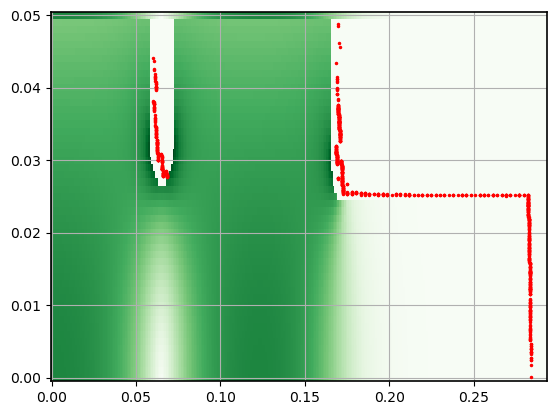

In [ ]:
Z,R = np.meshgrid(zz,rr)
plt.pcolormesh(Z,R,np.transpose(Emag),cmap="Greens")

ind = endind-4
                # z             #r
plt.plot(pos[:,ind,-1],np.sqrt(pos[:,ind,0]**2 + pos[:,ind,1]**2),'r.',markersize=3,alpha=1)
plt.grid()

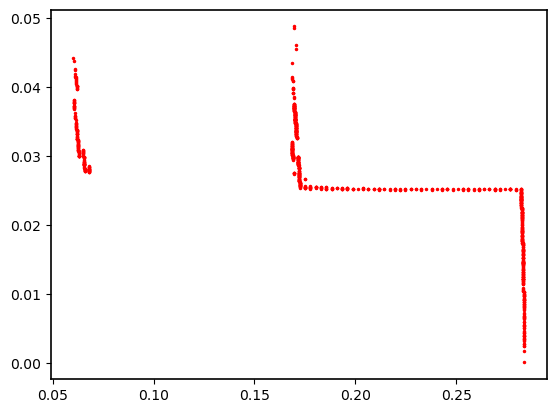

In [ ]:
plt.plot(pos[:,ind,-1],np.sqrt(pos[:,ind,0]**2 + pos[:,ind,1]**2),'r.',markersize=3,alpha=1)
#plt.plot(pos[:,0,-1]-np.mean(pos[:,0,-1]),np.sqrt(pos[:,0,0]**2 + pos[:,0,1]**2),'b.',markersize=3,alpha=1)